In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
class BatchNormNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.beta = nn.Parameter(torch.zeros(1))
    self.gamma = nn.Parameter(torch.ones(1))
  def forward(self, x):
    x_mean = x.mean(dim=0, keepdim=True)
    x_var = x.var(dim=0, keepdim=True, unbiased=False)
    x = (x - x_mean) / x_var.sqrt()
    return self.gamma * x + self.beta

In [6]:
a = torch.randn(20, 100)
m = nn.BatchNorm1d(100)
bnn = BatchNormNet()
print(m(a))
print(bnn(a))

tensor([[ 1.3483, -0.9951, -0.1254,  ...,  1.6405, -0.5620,  1.0797],
        [ 1.2634, -1.1975,  2.1092,  ...,  1.3965, -0.4039,  0.6459],
        [-0.2330, -0.4504, -1.2491,  ...,  0.2202,  0.6142, -0.8499],
        ...,
        [ 0.1230, -1.4007,  0.0965,  ...,  0.3755, -0.8766,  1.0208],
        [-1.1432, -0.4363,  1.4397,  ..., -0.7317, -0.7423, -1.2890],
        [-1.9365, -0.2201,  0.5817,  ..., -0.5212,  0.3327, -0.6149]],
       grad_fn=<NativeBatchNormBackward0>)
tensor([[ 1.3483, -0.9951, -0.1254,  ...,  1.6405, -0.5620,  1.0797],
        [ 1.2634, -1.1975,  2.1092,  ...,  1.3965, -0.4039,  0.6459],
        [-0.2330, -0.4504, -1.2491,  ...,  0.2202,  0.6142, -0.8500],
        ...,
        [ 0.1230, -1.4007,  0.0965,  ...,  0.3755, -0.8766,  1.0208],
        [-1.1433, -0.4363,  1.4397,  ..., -0.7317, -0.7423, -1.2891],
        [-1.9365, -0.2201,  0.5817,  ..., -0.5212,  0.3327, -0.6149]],
       grad_fn=<AddBackward0>)


In [ ]:
class NonNormalizedNet(nn.Module):
  def __init__(self):
    super().__init__()
    self.beta = nn.Parameter(torch.zeros(1))
    self.gamma = nn.Parameter(torch.ones(1))
  def forward(self, x):
    return self.gamma * x + self.beta

In [ ]:
x = torch.arange(1, 101, dtype=torch.float)
y = x + 20

In [ ]:
bnn = BatchNormNet()

In [ ]:
def l2_loss(pred, target):
  return ((pred - target) ** 2).mean()

In [ ]:
optimizer = torch.optim.SGD(bnn.parameters())

In [ ]:
from tqdm import tqdm
NUM_EPOCHS = 10000
losses = []
betas = []
gammas = []
loop = tqdm(range(NUM_EPOCHS))
bnn.train()
for epoch in loop:
  optimizer.zero_grad()
  pred = bnn(x)
  loss = l2_loss(pred, y)
  loss.backward()
  optimizer.step()
  losses.append(loss.item())
  betas.append(bnn.beta.item())
  gammas.append(bnn.gamma.item())
  loop.set_description(f'EPOCH {epoch + 1} | {NUM_EPOCHS}: loss {loss:.4f}')



EPOCH 10000 | 10000: loss 0.0000: 100%|██████████| 10000/10000 [00:18<00:00, 540.70it/s]


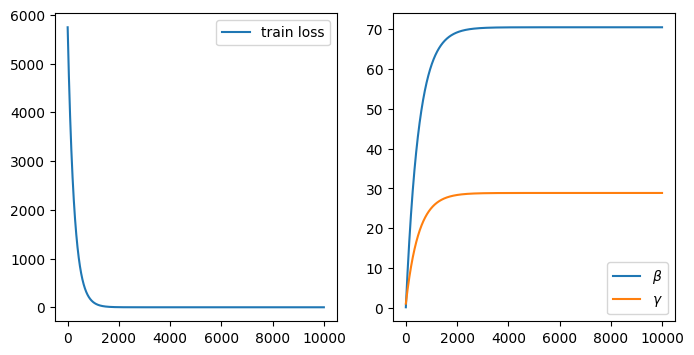

In [ ]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
axes = axes.flatten()
axes[0].plot(losses, label='train loss')
axes[0].legend()
axes[1].plot(betas, label=r'$\beta$')
axes[1].plot(gammas, label=r'$\gamma$')
axes[1].legend()
plt.show()

# Experiment:
Train neural network with `BN` and with out `BN` using `MNIST` then compare the convergence rate, number of iterations to achieve 70% accuracy.

In [ ]:
class BN(nn.Module):
  def __init__(self, dim=784, eps=1e-5):
    super().__init__()
    self.gamma = nn.Parameter(torch.randn(1, dim))
    self.beta = nn.Parameter(torch.randn(1, dim))
    self.eps = eps
  def forward(self, x):
    #x shape [num_batch, dim]
    ex = x.mean(dim=0, keepdim=True)
    varx = x.var(dim=0, keepdim=True)
    output = ((x - ex) / torch.sqrt(varx + self.eps)) * self.gamma + self.beta
    return output

In [ ]:
bn = BN()
x = torch.randn(10, 784)
o = bn(x)
print(o.shape)

torch.Size([10, 784])


In [ ]:
class BatchNormNet(nn.Module):
  def __init__(self, dim=784, num_classes=10):
    super().__init__()
    self.bn0 = BN(784)
    self.fc1 = nn.Linear(dim, 100)
    self.bn1 = BN(100)
    self.fc2 = nn.Linear(100, 100)
    self.bn2 = BN(100)
    self.fc3 = nn.Linear(100, 100)
    self.bn3 = BN(100)
    self.final = nn.Linear(100, num_classes)
  def forward(self, x):
    x = self.bn0(x)
    x1 = self.fc1(x)
    x1 = self.bn1(x1)
    x1 = F.relu(x1)
    x2 = self.fc2(x1)
    x2 = self.bn2(x2)
    x2 = F.relu(x2)
    x3 = self.fc3(x2)
    x3 = self.bn3(x3)
    x3 = F.relu(x3)
    logits = self.final(x3)
    return logits



In [ ]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
try:
    train_dataset = datasets.MNIST(
        root="./data",
        train=True,
        download=True,
        transform=transform
    )

    test_dataset = datasets.MNIST(
        root="./data",
        train=False,
        download=True,
        transform=transform
    )
except Exception as e:
    print(f"Error loading MNIST dataset: {e}")
    exit(1)
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=64,
    shuffle=True
)

test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=1000,
    shuffle=False
)

In [ ]:
for x, y in train_loader:
  x = x.squeeze(1)
  x = x.view(-1, 28 * 28)
  print(x.shape)
  print(y.shape)
  break

torch.Size([64, 784])
torch.Size([64])


In [ ]:
bnn = BatchNormNet().to('cuda')

In [ ]:
optimizer = torch.optim.SGD(bnn.parameters())
loss_fn = nn.CrossEntropyLoss()

In [ ]:
sum([p.numel() for p in bnn.parameters()])

101878

In [ ]:
from tqdm import tqdm
NUM_EPOCHS = 100
losses = []
accs = []
loop = tqdm(range(NUM_EPOCHS))
for epoch in loop:
  train_loss = 0.0
  acc = 0.0
  for x, y in train_loader:
    optimizer.zero_grad()
    x = x.to('cuda')
    x = x.unsqueeze(1)
    x = x.view(-1, 28 * 28)
    y = y.to('cuda')
    logits = bnn(x)
    # acc
    pred = logits.argmax(dim=-1)
    acc += (pred == y).sum().item()
    loss = loss_fn(logits, y)
    train_loss += loss
    loss.backward()
    optimizer.step()
  train_loss /= len(train_loader)
  losses.append(train_loss.item())
  accs.append(acc / len(train_dataset))
  loop.set_description(f'EPOCH [{epoch + 1} | {NUM_EPOCHS}]: loss {train_loss.item():.4f}, acc {acc / len(train_dataset):.4f}')



EPOCH [100 | 100]: loss 0.0470, acc 0.9867: 100%|██████████| 100/100 [27:19<00:00, 16.39s/it]


In [ ]:
class NonBatchNormNet(nn.Module):
  def __init__(self, dim=784, num_classes=10):
    super().__init__()
    self.fc1 = nn.Linear(dim, 100)
    self.fc2 = nn.Linear(100, 100)
    self.fc3 = nn.Linear(100, 100)
    self.final = nn.Linear(100, num_classes)
  def forward(self, x):
    x1 = self.fc1(x)
    x1 = F.relu(x1)
    x2 = self.fc2(x1)
    x2 = F.relu(x2)
    x3 = self.fc3(x2)
    x3 = F.relu(x3)
    logits = self.final(x3)
    return logits



In [ ]:
nnn = NonBatchNormNet().to('cuda')
optimizer = torch.optim.SGD(nnn.parameters())
loss_fn = nn.CrossEntropyLoss()

In [ ]:
from tqdm import tqdm
NUM_EPOCHS = 100
losses1 = []
accs1 = []
loop = tqdm(range(NUM_EPOCHS))
for epoch in loop:
  train_loss = 0.0
  acc = 0.0
  for x, y in train_loader:
    optimizer.zero_grad()
    x = x.to('cuda')
    x = x.unsqueeze(1)
    x = x.view(-1, 28 * 28)
    y = y.to('cuda')
    logits = nnn(x)
    # acc
    pred = logits.argmax(dim=-1)
    acc += (pred == y).sum().item()
    loss = loss_fn(logits, y)
    train_loss += loss
    loss.backward()
    optimizer.step()
  train_loss /= len(train_loader)
  losses1.append(train_loss.item())
  accs1.append(acc / len(train_dataset))
  loop.set_description(f'EPOCH [{epoch + 1} | {NUM_EPOCHS}]: loss {train_loss.item():.4f}, acc {acc / len(train_dataset):.4f}')



EPOCH [100 | 100]: loss 0.0962, acc 0.9727: 100%|██████████| 100/100 [23:44<00:00, 14.24s/it]


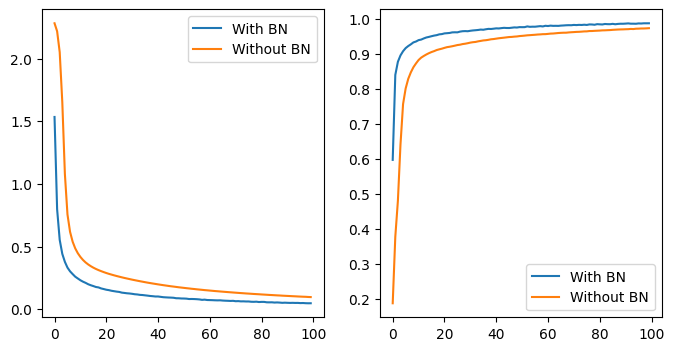

In [ ]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))
axes = axes.flatten()
axes[0].plot(losses, label='With BN')
axes[0].plot(losses1, label='Without BN')
axes[0].legend()
axes[1].plot(accs, label='With BN')
axes[1].plot(accs1, label='Without BN')
axes[1].legend()
plt.show()